In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

import ee

In [36]:
data = pd.read_csv('01_data.csv', index_col=0, parse_dates=True)
data

,precip_in_inc,precip_in_cum,stage_ft_BT,flood_stage_BT,stage_ft_SC,flood_stage_SC,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,month,wy,D0,D1,D2,D3,D4,wildfire_percent
2008-10-01 00:00:00,0.0,0.00,2.83,0.0,3.89,0.0,0.0000,10.8,1.43,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:15:00,0.0,0.00,2.83,0.0,3.88,0.0,0.0000,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:30:00,0.0,0.00,2.83,0.0,3.88,0.0,0.0000,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 00:45:00,0.0,0.00,2.83,0.0,3.88,0.0,0.0000,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
2008-10-01 01:00:00,0.0,0.00,2.83,0.0,3.88,0.0,0.0000,10.8,1.26,2008,10,2009,100.0,100.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17 23:00:00,0.0,47.19,3.79,0.0,2.64,0.0,-0.7088,54.0,52.90,2024,6,2024,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-17 23:15:00,0.0,47.19,3.79,0.0,2.65,0.0,-0.7088,54.0,53.70,2024,6,2024,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-17 23:30:00,0.0,47.19,3.79,0.0,2.63,0.0,-0.7088,54.0,52.10,2024,6,2024,0.0,0.0,0.0,0.0,0.0,0.0
2024-06-17 23:45:00,0.0,47.19,3.78,0.0,2.65,0.0,-0.7088,53.4,53.70,2024,6,2024,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data.dtypes

precip_in_inc               float64
precip_in_cum               float64
stage_ft_BT                 float64
flood_stage_BT              float64
stage_ft_SC                 float64
flood_stage_SC              float64
ndwi_watershed_green_nir    float64
q_cfs_peak_BT_int           float64
q_cfs_peak_SC_int           float64
cy                            int64
month                         int64
wy                            int64
D0                          float64
D1                          float64
D2                          float64
D3                          float64
D4                          float64
wildfire_percent            float64
dtype: object

## Random Forest Model
Build Random forest model with several variables lagged, to get general idea of feature importance and model fit capabilities as a baseline. 

In [4]:
data_rfr = data.copy()
months_to_lag = [1, 2, 3, 4] 
drought_index_ints = [0, 1, 2, 3, 4]

for m in months_to_lag:
    data_rfr['lag_precip_' + str(m) + 'months'] = data_rfr['precip_in_inc'].shift(-30*m) # shift data back, 30 days in a month
    for d in drought_index_ints:
        data_rfr['lag_d' + str(d) + '_' + str(m) + 'months'] = data_rfr['D' + str(d)].shift(-30*m) #shift back data

hours_to_lag = [1, 2, 5, 14, 30]
for h in hours_to_lag:
    data_rfr['lag_precip_' + str(h) + 'days'] = data_rfr['precip_in_inc'].shift(h) # shift data back h hours


data_rfr.dropna(inplace=True) #drop null values created with shift functions - will be most recent 4 months
data_rfr.head()


,precip_in_inc,precip_in_cum,stage_ft_BT,flood_stage_BT,stage_ft_SC,flood_stage_SC,ndwi_watershed_green_nir,q_cfs_peak_BT_int,q_cfs_peak_SC_int,cy,...,lag_d0_4months,lag_d1_4months,lag_d2_4months,lag_d3_4months,lag_d4_4months,lag_precip_1days,lag_precip_2days,lag_precip_5days,lag_precip_14days,lag_precip_30days
2008-10-01 07:30:00,0.0,0.0,2.85,0.0,3.86,0.0,0.0,11.7,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 07:45:00,0.0,0.0,2.85,0.0,3.85,0.0,0.0,11.7,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 08:00:00,0.0,0.0,2.85,0.0,3.85,0.0,0.0,11.7,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 08:15:00,0.0,0.0,2.86,0.0,3.85,0.0,0.0,12.2,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-10-01 08:30:00,0.0,0.0,2.86,0.0,3.85,0.0,0.0,12.2,1.11,2008,...,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


training model score:  0.46438664306574284
test model score:  0.4665003309563107


<Axes: >

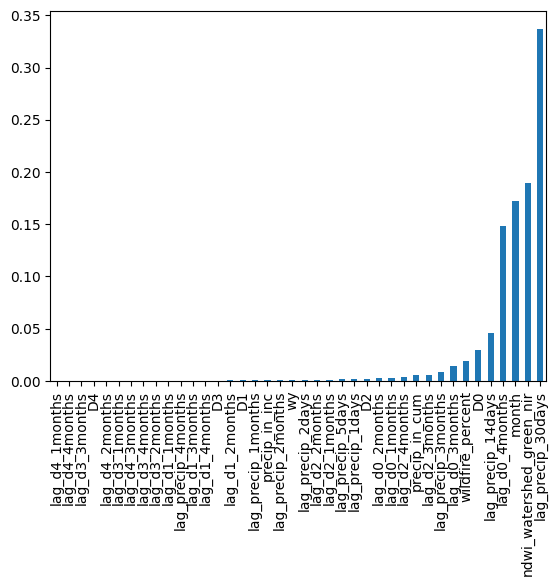

In [5]:
X = data_rfr.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'q_cfs_peak_BT_int', 'cy'], axis=1)
y = data_rfr['q_cfs_peak_SC_int']
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(X, y, test_size=0.2, random_state=777)

rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)
rfr.fit(X_train_SC, y_train_SC)
y_pred_SC = rfr.predict(X_test_SC)

print('training model score: ', rfr.score(X_train_SC, y_train_SC))
print('test model score: ', rfr.score(X_test_SC, y_test_SC))

#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train_SC.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


training model score:  0.9657489816241319
test model score:  0.9634800429163534


<Axes: >

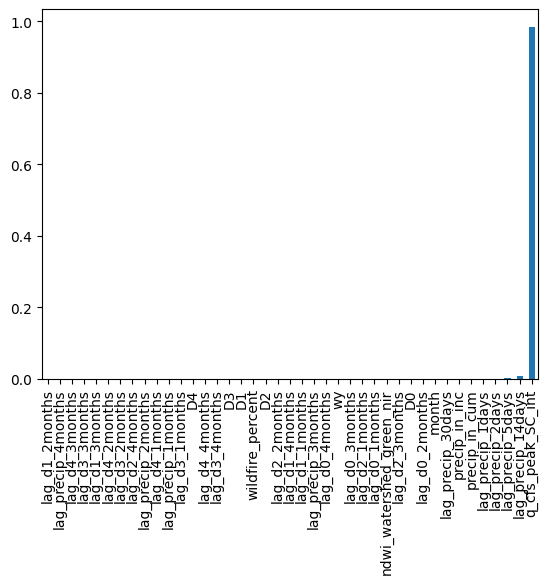

In [6]:
X = data_rfr.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_BT_int', 'cy'], axis=1)
y = data_rfr['q_cfs_peak_BT_int']
X_train_BT, X_test_BT, y_train_BT, y_test_BT = train_test_split(X, y, test_size=0.2, random_state=777)

rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)
rfr.fit(X_train_BT, y_train_BT)
y_pred_BT = rfr.predict(X_test_BT)
print('training model score: ', rfr.score(X_train_BT, y_train_BT))
print('test model score: ', rfr.score(X_test_BT, y_test_BT))

#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train_BT.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


Text(0, 0.5, 'observed streamflow')

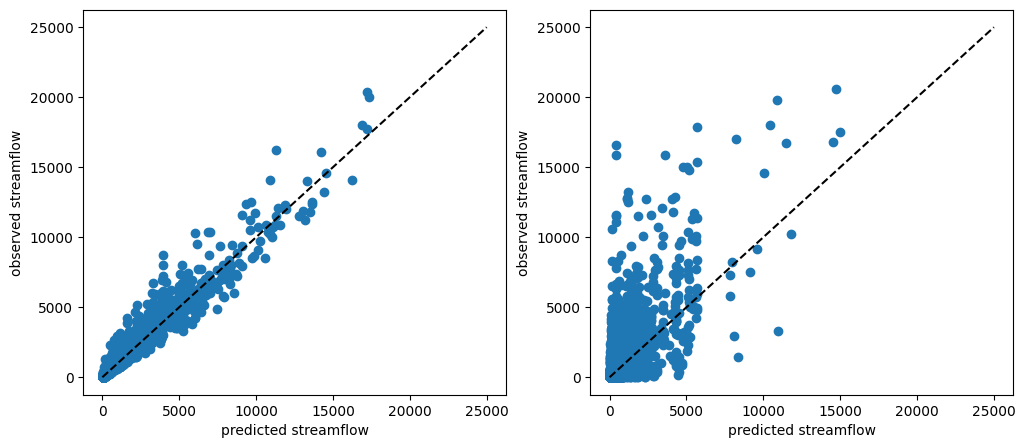

In [7]:
## plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(y_pred_BT, y_test_BT)
ax1.plot((0, 25000), (0, 25000), 'k', linestyle='--')
ax1.set_xlabel('predicted streamflow')
ax1.set_ylabel('observed streamflow')


ax2.scatter(y_pred_SC, y_test_SC)
ax2.plot((0, 25000), (0, 25000), 'k', linestyle='--')
ax2.set_xlabel('predicted streamflow')
ax2.set_ylabel('observed streamflow')

## RFR Results
Most importance features are: 
- precip and lag of precip is obviously most important model feature.

Model underpredicts flow peaks (typical of RFR)

RFR model appears to explain 85% of model variability (R_squared), but overfits in the train period (r_squared for test is 0.65)
Could possibly improve with different hyperparameters, but good first gut check model


## Random Forest Classifier of flood stage



training model score:  0.7041666666666667
test model score:  0.6915887850467289


array([1., 4., 2., 3.])

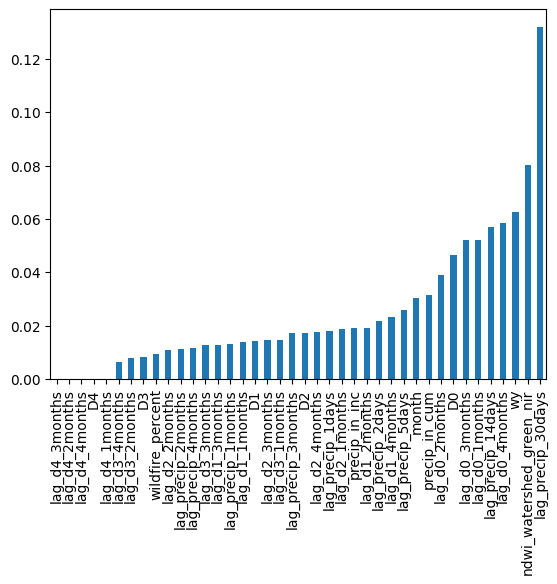

In [55]:
data_rfc = data_rfr.loc[data_rfr['flood_stage_SC'] >= 1, :]
# data_rfc = data.copy()
data_rfc.loc[:, ['flood_stage_SC']] = data_rfc[['flood_stage_SC']].astype('int')
X = data_rfc.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'cy', 'q_cfs_peak_BT_int'], axis=1)
y = data_rfc['flood_stage_SC']
le = LabelEncoder()
# y = le.fit_transform(y)
# y = np.int(np.array(y))
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(X, y, test_size=0.25, random_state=777)

rfc = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=777)
rfc.fit(X_train_SC, y_train_SC)
y_pred_SC = rfc.predict(X_test_SC)

print('training model score: ', rfc.score(X_train_SC, y_train_SC))
print('test model score: ', rfc.score(X_test_SC, y_test_SC))

#next, we'll take a look at feature importance
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=X_train_SC.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)
y_train_SC.unique()

accuracy =  0.6915887850467289
precision =  0.5857425118489157
recall =  0.6915887850467289


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


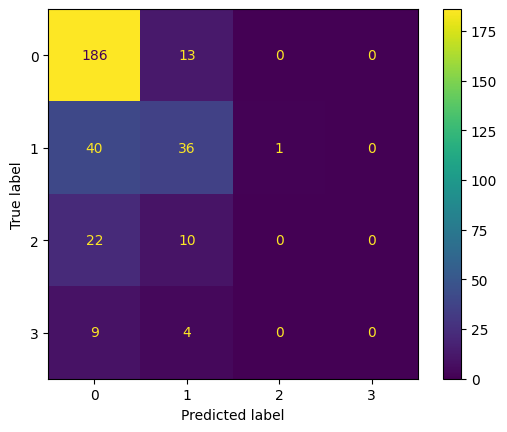

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_SC, y_pred_SC))

disp.plot()

print('accuracy = ', accuracy_score(y_test_SC, y_pred_SC))
print('precision = ', precision_score(y_test_SC, y_pred_SC, average='weighted'))
print('recall = ', recall_score(y_test_SC, y_pred_SC, average='weighted'))

training model score:  0.678125
test model score:  0.5950155763239875


<Axes: >

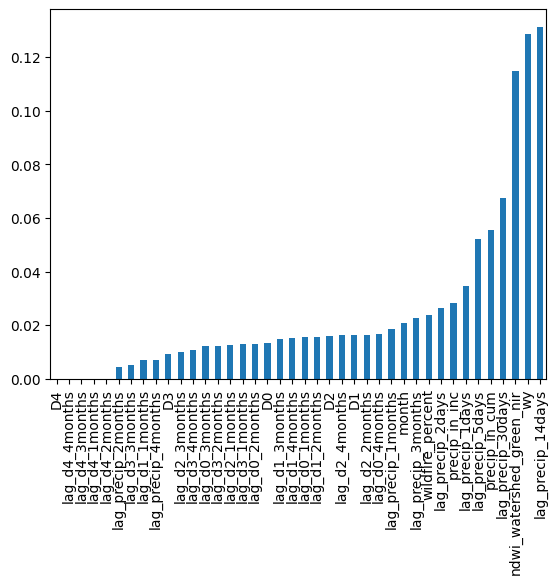

In [57]:

X = data_rfc.drop(['stage_ft_BT', 'stage_ft_SC', 'flood_stage_SC', 'flood_stage_BT', 'q_cfs_peak_SC_int', 'cy', 'q_cfs_peak_BT_int'], axis=1)
y = data_rfc['flood_stage_BT']
X_train_BT, X_test_BT, y_train_BT, y_test_BT = train_test_split(X, y, test_size=0.25, random_state=777)

rfc_BT = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=777)
rfc_BT.fit(X_train_BT, y_train_BT)
y_pred_BT = rfc_BT.predict(X_test_BT)
print('training model score: ', rfc_BT.score(X_train_BT, y_train_BT))
print('test model score: ', rfc_BT.score(X_test_BT, y_test_BT))

#next, we'll take a look at feature importance
importances = rfc_BT.feature_importances_
forest_importances = pd.Series(importances, index=X_train_BT.columns)

fig, ax = plt.subplots()
forest_importances.sort_values().plot.bar(ax=ax)


accuracy =  0.5950155763239875
precision =  0.6001418012687941
recall =  0.5950155763239875


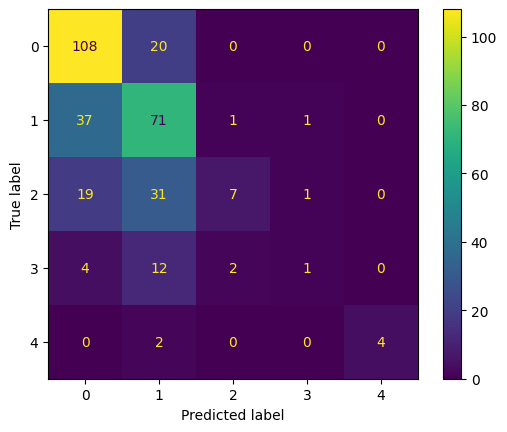

In [58]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_BT, y_pred_BT))

disp.plot()

print('accuracy = ', accuracy_score(y_test_BT, y_pred_BT))
print('precision = ', precision_score(y_test_BT, y_pred_BT, average='weighted'))
print('recall = ', recall_score(y_test_BT, y_pred_BT, average='weighted'))

## Summary of work

## Next steps
- maybe switch model to daily?
- train model on longer period
- add in cumulative precip

#### LSTM Resources Used for this notebook

- https://github.com/MohammadFneish7/Keras_LSTM_Diagram
- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
- https://gabenosek.medium.com/time-series-stock-prediction-with-lstm-eb04f2224c22
